## Time series Forcasting 

In [51]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
plt.style.use('bmh')


In [35]:
#read the files. 
train = pd.read_csv("Train.csv")
test  = pd.read_csv("Test.csv")

In [36]:
#duplicate the data file so it can be called later.
train_original = train.copy()
test_original  = test.copy()

In [37]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object,
 ID           int64
 Datetime    object
 dtype: object)

In [38]:
#check the size of the data 
train.shape, test.shape

((18288, 3), (5112, 2))

In [39]:
#convert the date form from object to datetime format in the train and test data set.
train['Datetime']   = pd.to_datetime(train.Datetime, format ='%d-%m-%Y %H:%M')
test['Datetime']    = pd.to_datetime(test.Datetime, format ='%d-%m-%Y %H:%M')
train_original['Datetime']   = pd.to_datetime(train_original.Datetime, format ='%d-%m-%Y %H:%M')
test_original['Datetime']    = pd.to_datetime(test_original.Datetime, format ='%d-%m-%Y %H:%M')

## Feature Extration

### Use the hypothesis listed to make the feature extraction move. 

In [42]:
#We highlited that weekend will have less air travel than weekdays. 
for i in (train, test, train_original, test_original):
    i['year']   =   i.Datetime.dt.year
    i['month']  =   i.Datetime.dt.month
    i['day']    =   i.Datetime.dt.day
    i['Hour']   =   i.Datetime.dt.hour

In [43]:
#N.B To identify weekends 5 and 6 are weekendas
train['day of week'] = train['Datetime'].dt.dayofweek
temp = train['Datetime']

In [44]:
#function to classify the records
#weekend is 1
#week day is 0
def rowclass(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1 
    else:
        return 0

#apply the function rowclass
temp2 = train['Datetime'].apply(rowclass)
train['weekend'] = temp2

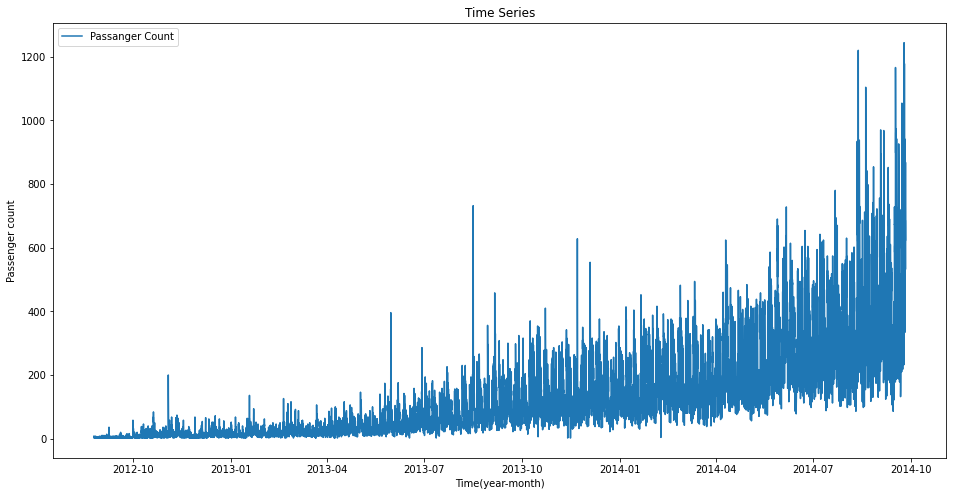

In [46]:
#view time series
train.index = train['Datetime']
#remove the id variable
trainN = train.drop('ID',1)

trainV = trainN['Count']
plt.figure(figsize = (16,8))
plt.plot(trainV, label ='Passanger Count')
plt.title('Time Series')
plt.xlabel('Time(year-month)')
plt.ylabel('Passenger count')
plt.legend(loc ='best')

### Exploratory Data Analysis

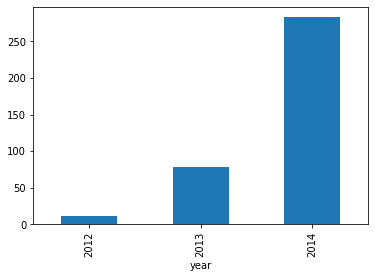

In [48]:
#Verify hypothesis 
train.groupby('year')['Count'].mean().plot.bar()

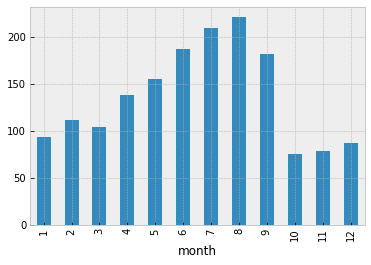

In [57]:
train.groupby('month')['Count'].mean().plot.bar()

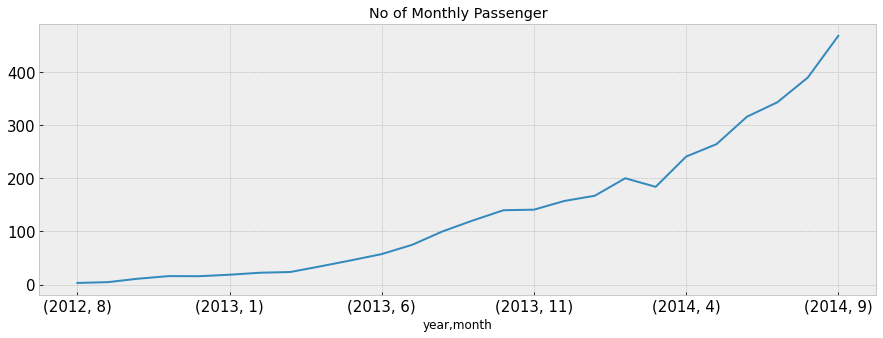

In [60]:
temp =train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize = (15, 5), title = 'Number of Monthly Passenger', fontsize =15)

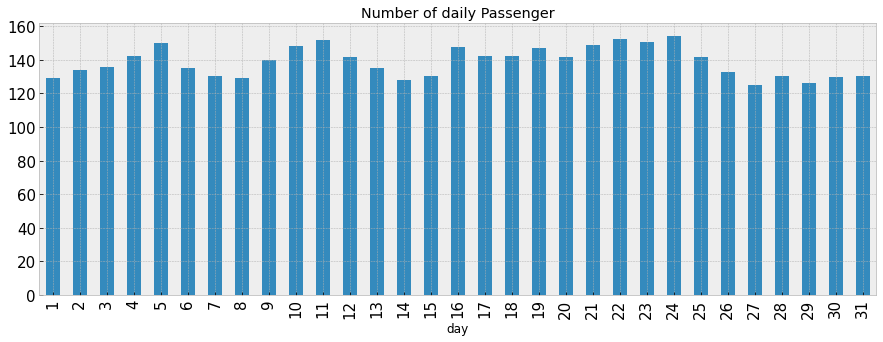

In [62]:
train.groupby('day')['Count'].mean().plot.bar(figsize = (15, 5), title = 'Average daily Passenger', fontsize =15)

Not much insight is gotton from the daily chart.
we go ahead to plot the monthly chart

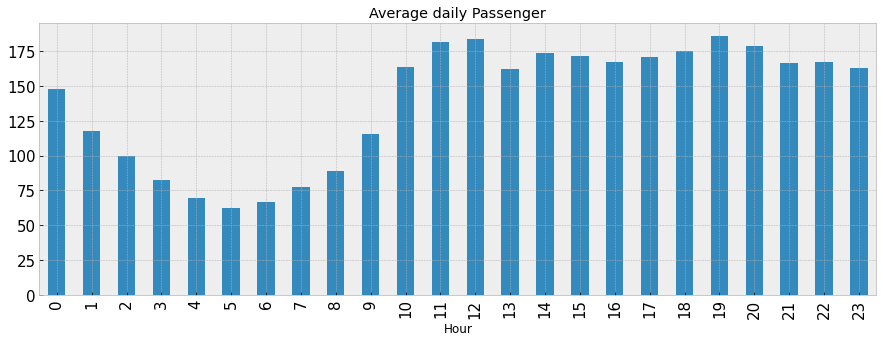

In [64]:
train.groupby('Hour')['Count'].mean().plot.bar(figsize = (15, 5), title = 'Average daily Passenger', fontsize =15)